Hyperparameter Tuning

Import necessary libraries

In [1]:
# Import necessary libraries
import random
import os
os.chdir("C:/Users/Pauli/OneDrive/Dokumente/Uni/Masterarbeit/code/preprocessing")
import pandas as pd
import numpy as np
import pickle
import ast

#nn modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

#metrics and plotting
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
#other
from datasplit import get_datasplit
from featurescaling import scale_features
from earlystopper import EarlyStopper
import copy

# set up decimal display options
np.set_printoptions(precision=3)
pd.options.display.precision = 3

# global random seed
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)

Load Data

In [2]:
#load necessary data
#open multi index pickle file
with open("data_split_multiind.pkl", "rb") as f:
    [ind_train, ind_val, ind_test, ind_holdout] = pickle.load(f)

#Load Kinase-ligand-K_off dataset
df_target_value = pd.read_excel("kinase_ligand_k_off.xlsx", sheet_name='kinase_ligand_k_off')
df_target_value = df_target_value.dropna(subset=["log_koff"])  #drop rows with missing target value

#choose if full or pocket kinase sequences
feature_set_kinase = "Pocket_Sequences_propy"   # "Sequences_propy" or "Pocket_Sequences_propy"
feature_set_ligand = "Morgan_Fingerprints"  # "Mordred_Features" or "Morgan_Fingerprints"

#prepare feature dataframe
    
df_ligand = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Ligand_"+feature_set_ligand)
df_kinase = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Kinase_"+feature_set_kinase)


In [3]:
#merge dataframes
df = pd.merge(df_target_value, df_ligand, on="ligand", how="left") 
df_all = pd.merge(df, df_kinase, on="kinase", how="left")
df_all.dropna(subset=["log_koff"], inplace=True)  #drop rows with missing target value

#get iris split from my cleaned data set
df_train = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_train)].copy()
df_val = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_val)].copy()
df_test = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_test)].copy()
df_holdout = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_holdout)].copy()
#merge train and val for final training
#df_train = pd.merge(df_train, df_val, how="outer")

In [4]:
ligand_selectors = {
    "Morgan_Fingerprints":   lambda df: df.loc[:, "morgan__0":"morgan__2047"],
    None:                    lambda df: df.iloc[:, 0:0],  # empty
}

kinase_selectors = {
    "Sequences_propy":           lambda df: df.loc[:, "DPC"], # takes just the best descriptor
    "Pocket_Sequences_propy":    lambda df: df.loc[:, "TPC"], # takes just the best descriptor
    None:                        lambda df: df.iloc[:, 0:0],  # empty
}

In [5]:
ligand_cols = ligand_selectors[feature_set_ligand](df_train).columns.tolist()
kinase_cols = kinase_selectors[feature_set_kinase](df_train).copy()

In [6]:
import ast
def parse_list_cell(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)   # safe parsing of stringified list
        except Exception:
            return np.nan
    return x  # already a list/sequence

#df_train["AAC"] = df_train["AAC"].apply(parse_list_cell)


In [7]:
from sklearn.preprocessing import MinMaxScaler
#features
X_ligand_train = df_train[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
X_kinase_train = df_train["TPC"].apply(parse_list_cell).tolist() 
y_raw = df_train["log_koff"].values.reshape(-1, 1) #target value
#independet scalers
x_scaler_ligand = MinMaxScaler()
x_scaler_kinase = MinMaxScaler()
y_scaler = MinMaxScaler()

#fit scalers
y_scaler.fit(y_raw)

x_scaler_ligand.fit(X_ligand_train) 
x_scaler_kinase.fit(X_kinase_train)

MinMaxScaler()

In [8]:
def prepare_tensors(df, ligand_cols, y_scaler, x_scaler_ligand, x_scaler_kinase):
        y = (df["log_koff"].values).reshape(-1, 1)
        y_scaled = y_scaler.transform(y)
        X_ligand = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X_kinase = df["TPC"].apply(parse_list_cell).tolist()
        X_scaled_kinase = x_scaler_kinase.transform(X_kinase)
        X = np.hstack([X_scaled_kinase, X_ligand])
            
        X_tensor = torch.tensor(X, dtype=torch.float32) # Konvertieren in Tensoren
        y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
        return TensorDataset(X_tensor, y_tensor)

In [9]:
# Split des Datensets in test und training data. Hhange former holdout to the final test set, change former test set to validation set
train_ds = prepare_tensors(df_train, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand)
test_ds = prepare_tensors(df_test, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand) 
val_ds = prepare_tensors(df_val, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand) 
holdout_ds = prepare_tensors(df_holdout, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand)

#create minibatches of the specified size
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

#how to access the tensor shapes if needed
X_tensor = train_ds.tensors[0]
y_tensor = train_ds.tensors[1]
X_test = test_ds.tensors[0]
y_test = test_ds.tensors[1]


Hyperparameter Tuning: Running through every combination of hidden dimesions and dropout ratios


Testing model with hidden1=256, hidden2=128, dropout=0.1
Final TEST loss: 0.0110


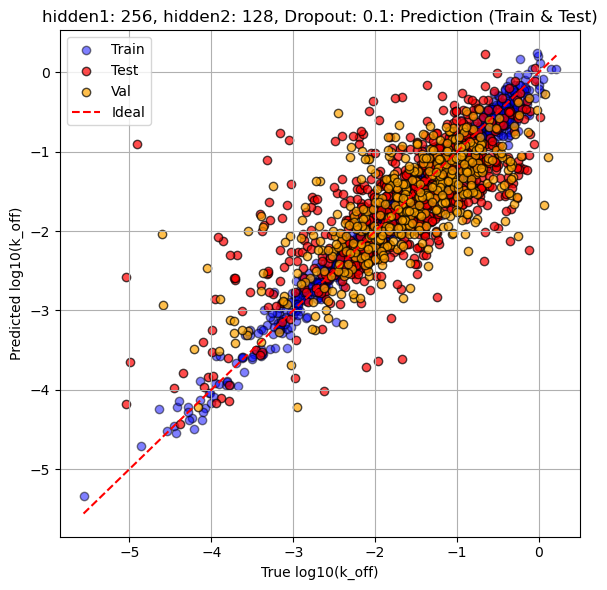

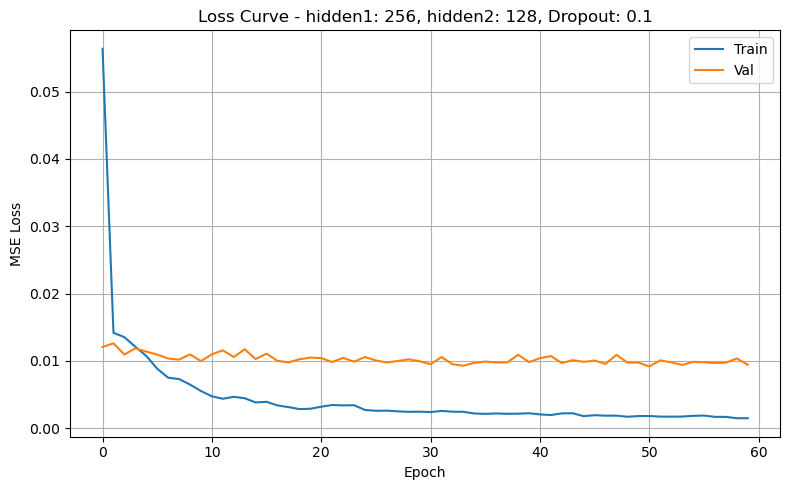

MSE: 0.3657, R² Test 0.5170

Testing model with hidden1=256, hidden2=128, dropout=0.3
Final TEST loss: 0.0107


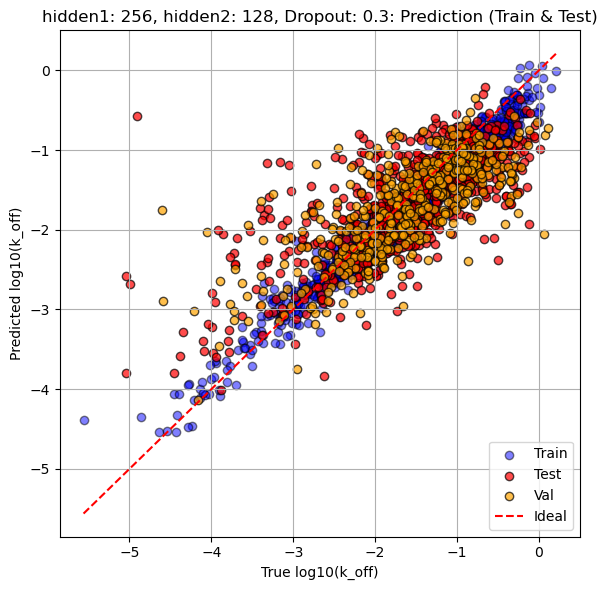

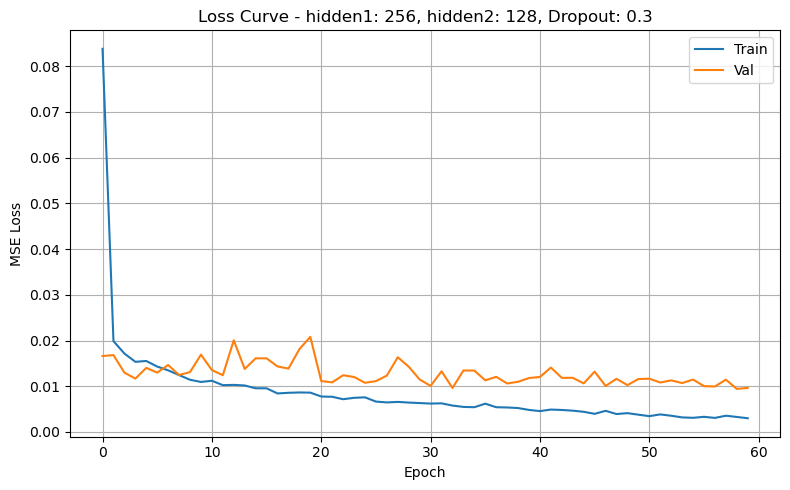

MSE: 0.3519, R² Test 0.5353

Testing model with hidden1=256, hidden2=128, dropout=0.5
Final TEST loss: 0.0106


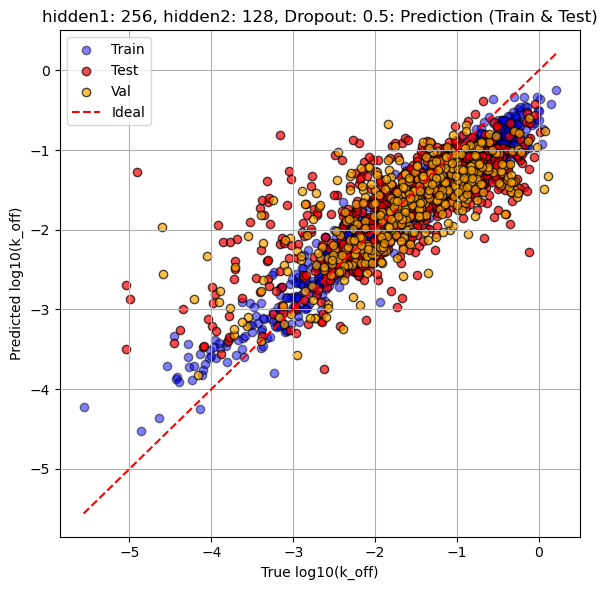

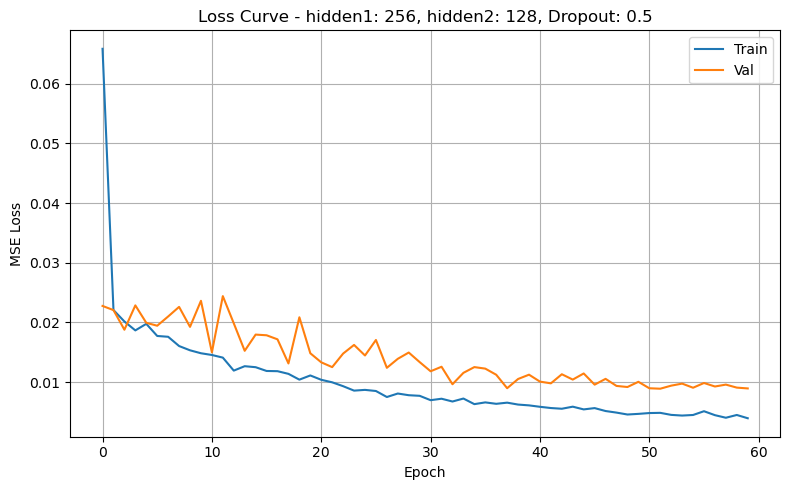

MSE: 0.3484, R² Test 0.5398

Testing model with hidden1=256, hidden2=256, dropout=0.1
Final TEST loss: 0.0113


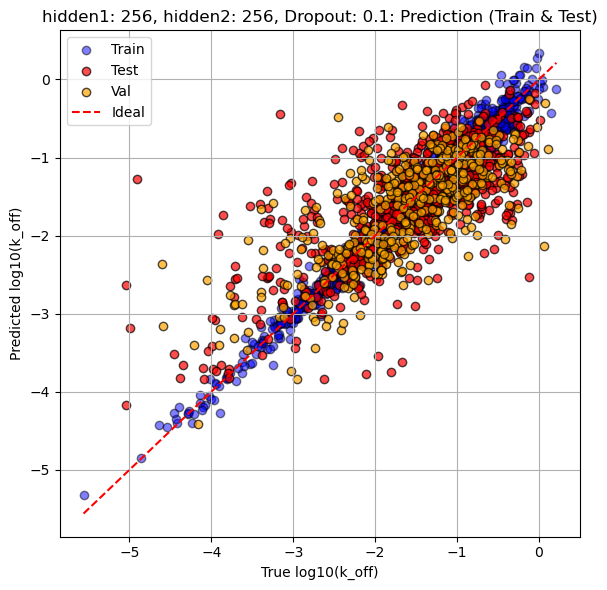

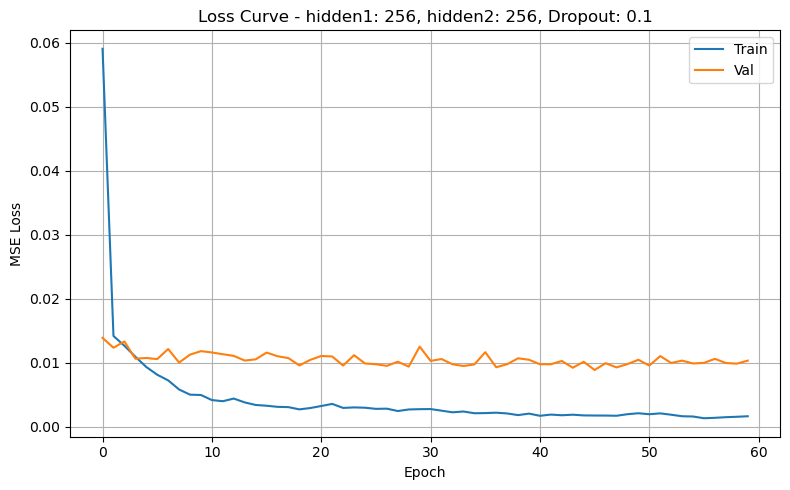

MSE: 0.3709, R² Test 0.5102

Testing model with hidden1=256, hidden2=256, dropout=0.3
Final TEST loss: 0.0113


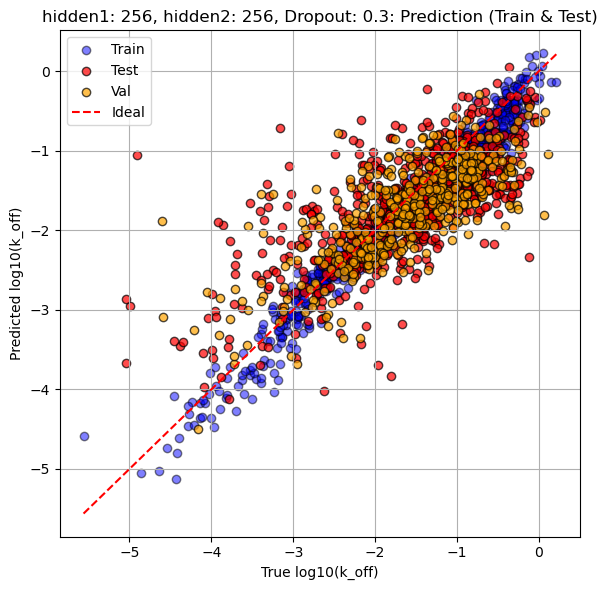

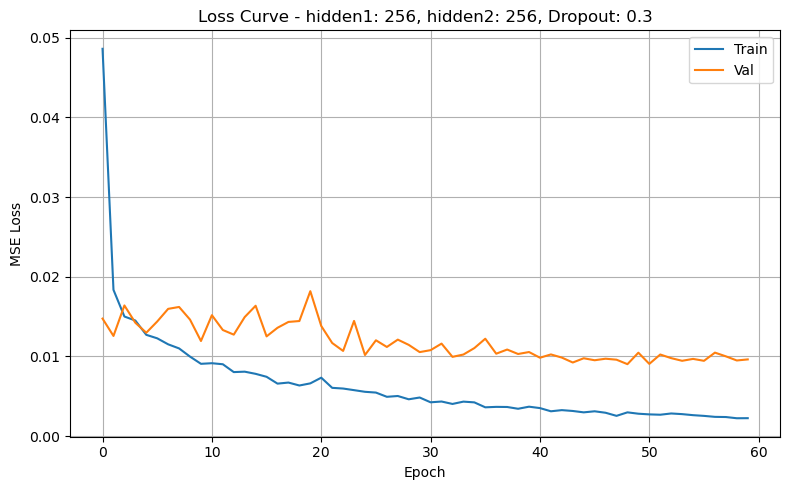

MSE: 0.3733, R² Test 0.5070

Testing model with hidden1=256, hidden2=256, dropout=0.5
Final TEST loss: 0.0107


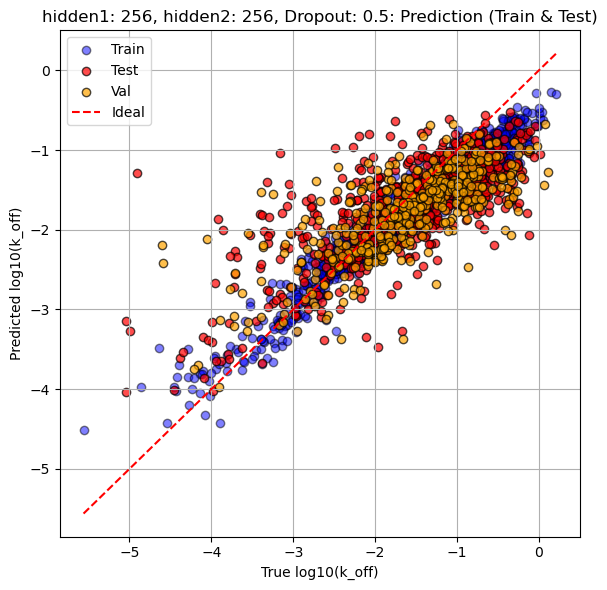

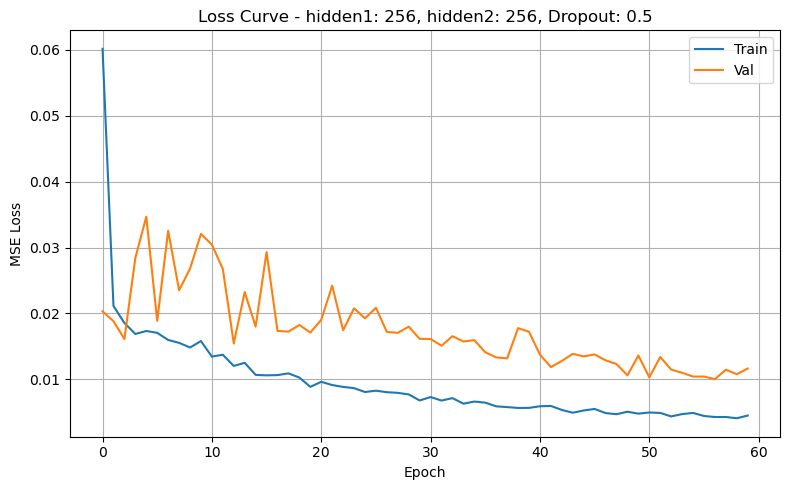

MSE: 0.3486, R² Test 0.5395

Testing model with hidden1=512, hidden2=128, dropout=0.1
Final TEST loss: 0.0111


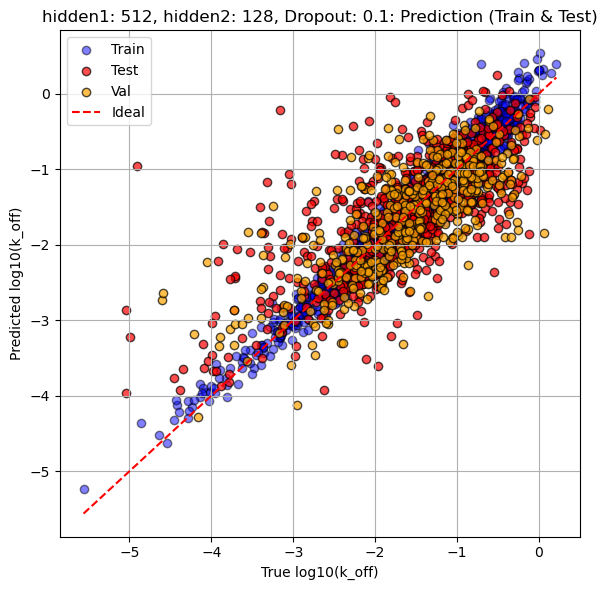

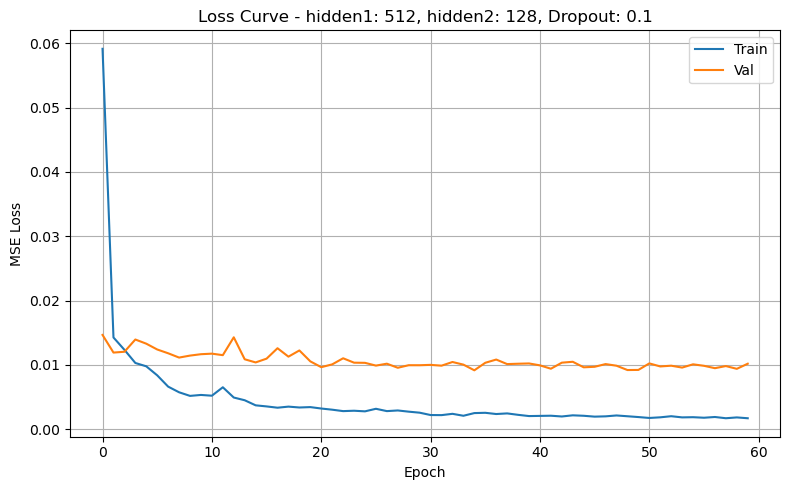

MSE: 0.3661, R² Test 0.5165

Testing model with hidden1=512, hidden2=128, dropout=0.3
Final TEST loss: 0.0108


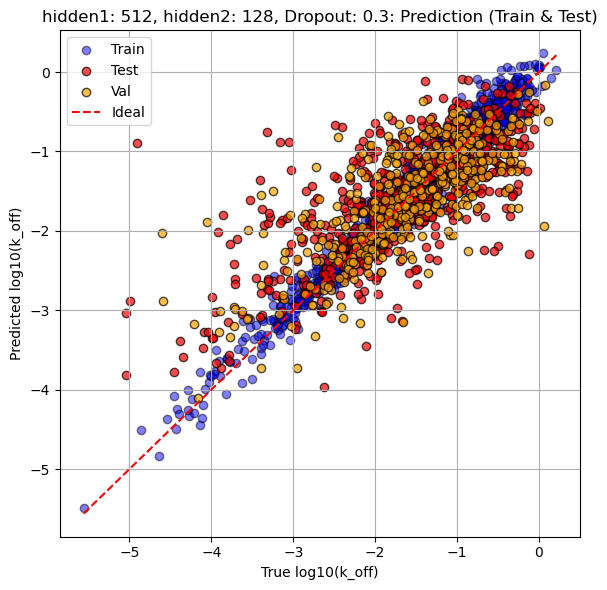

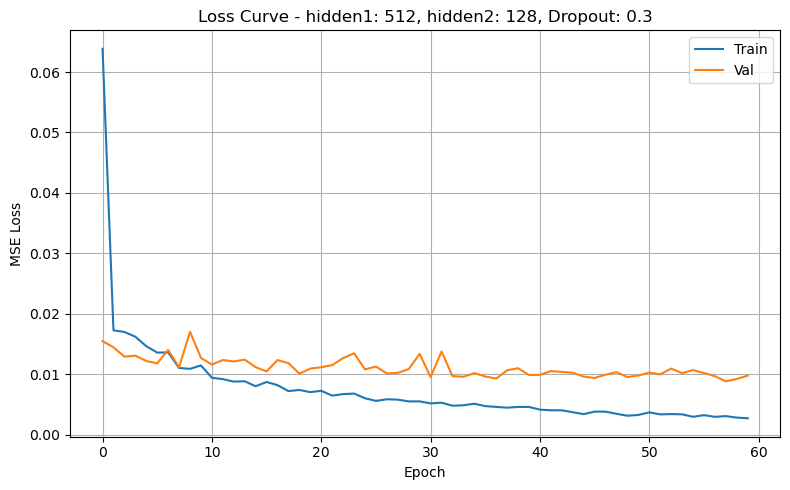

MSE: 0.3579, R² Test 0.5273

Testing model with hidden1=512, hidden2=128, dropout=0.5
Final TEST loss: 0.0107


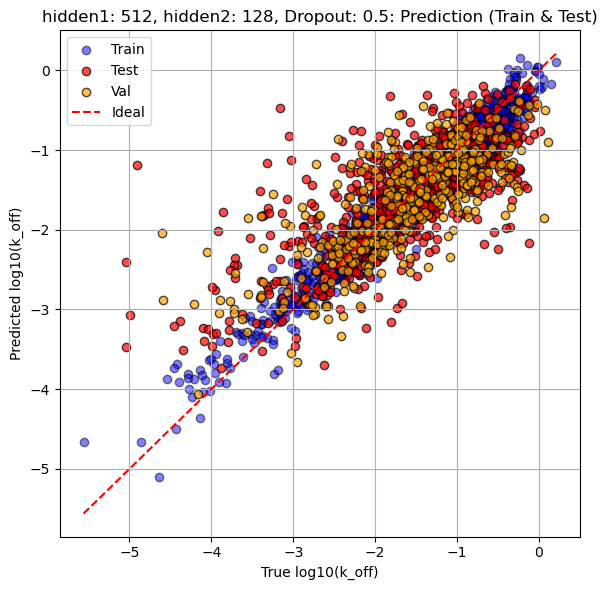

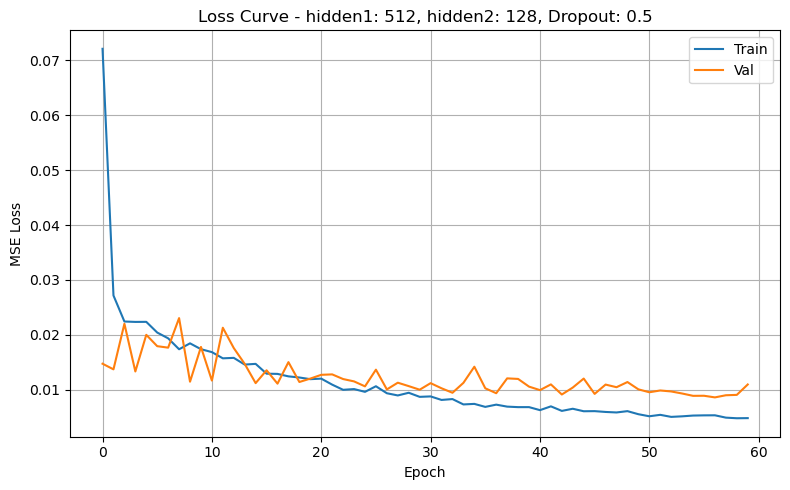

MSE: 0.3533, R² Test 0.5333

Testing model with hidden1=512, hidden2=256, dropout=0.1
Final TEST loss: 0.0107


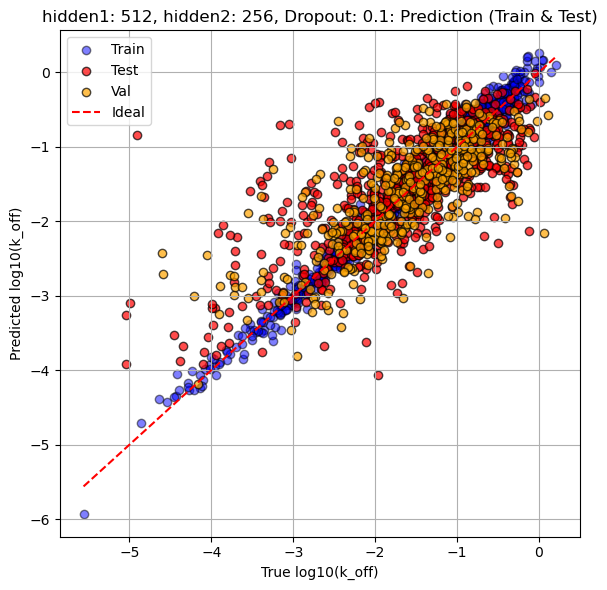

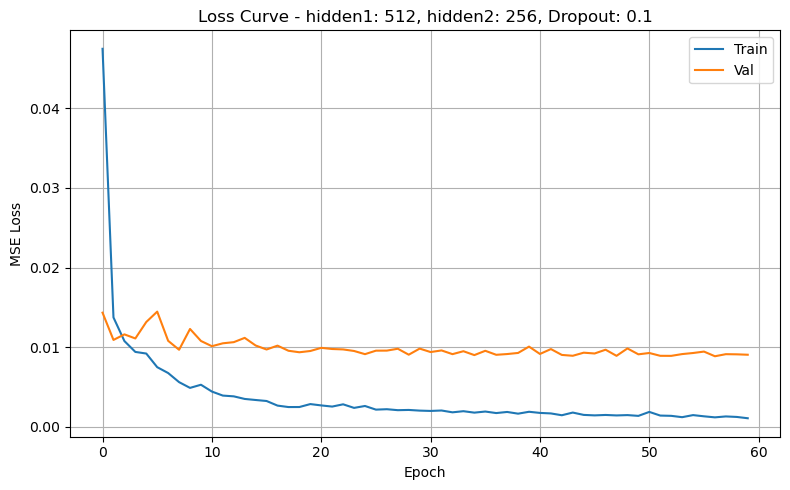

MSE: 0.3476, R² Test 0.5408

Testing model with hidden1=512, hidden2=256, dropout=0.3
Final TEST loss: 0.0104


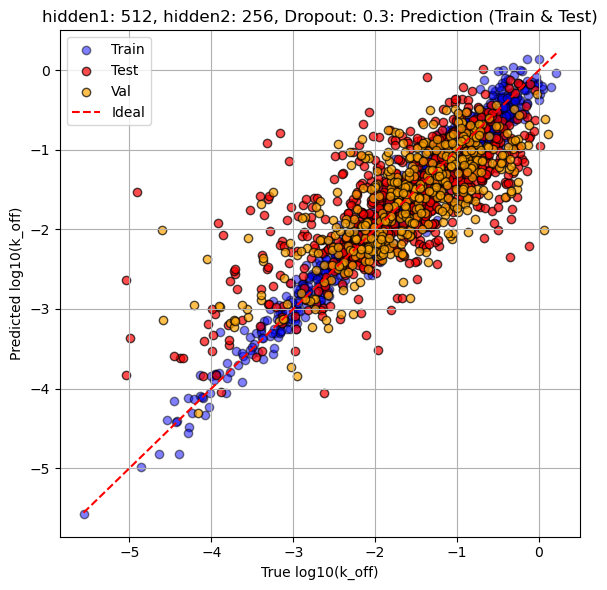

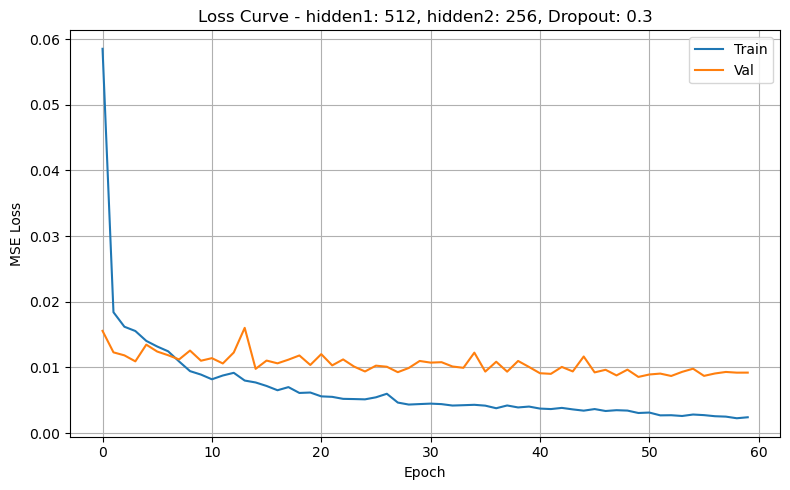

MSE: 0.3449, R² Test 0.5445

Testing model with hidden1=512, hidden2=256, dropout=0.5
Final TEST loss: 0.0106


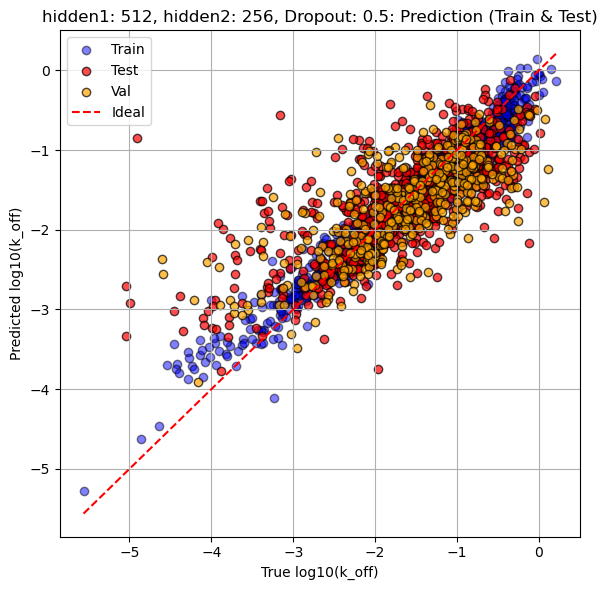

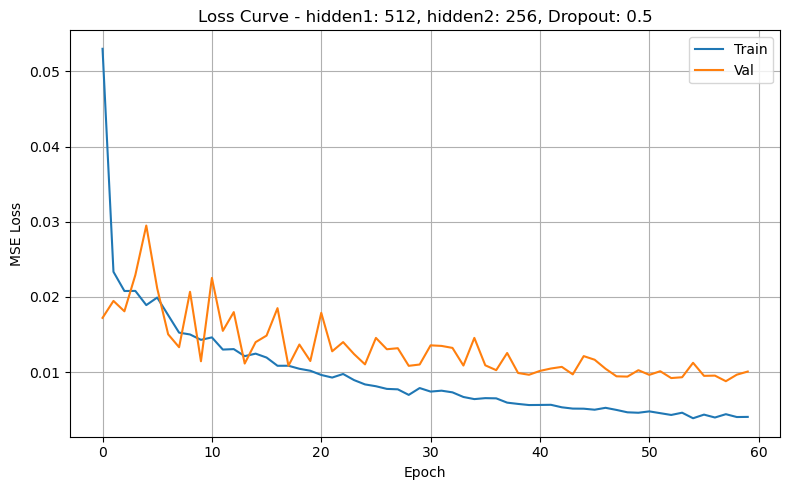

MSE: 0.3495, R² Test 0.5384

Testing model with hidden1=1024, hidden2=128, dropout=0.1
Final TEST loss: 0.0107


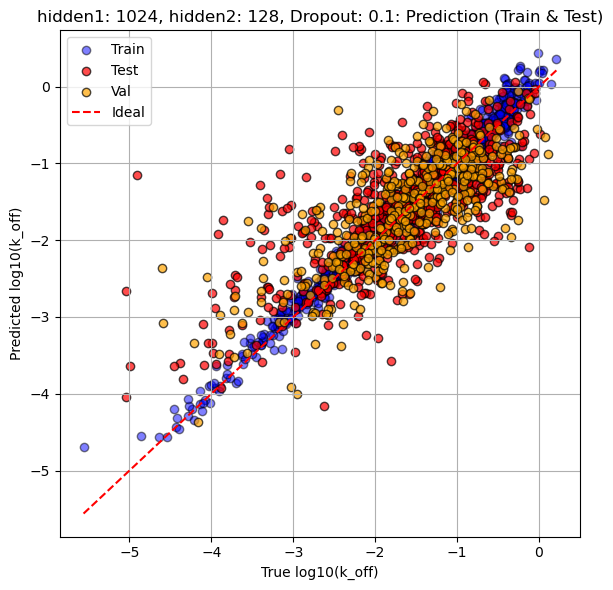

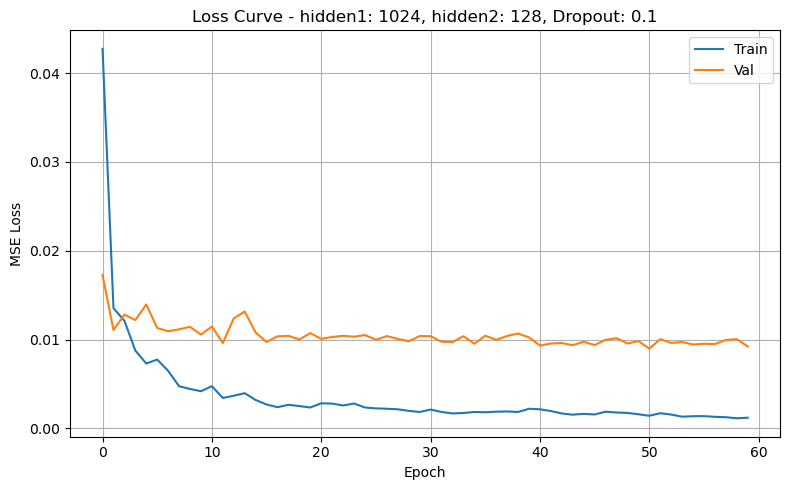

MSE: 0.3515, R² Test 0.5357

Testing model with hidden1=1024, hidden2=128, dropout=0.3
Final TEST loss: 0.0104


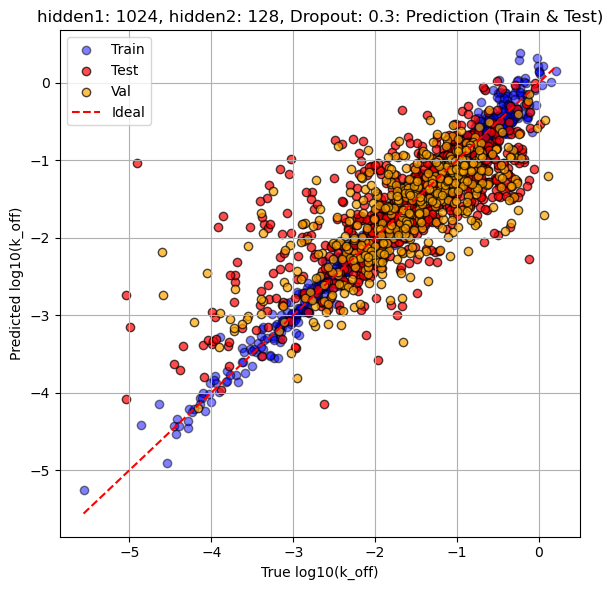

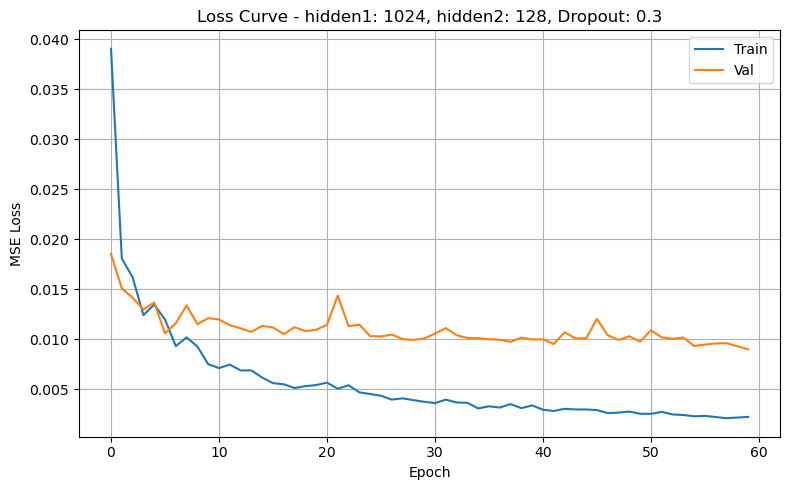

MSE: 0.3409, R² Test 0.5497

Testing model with hidden1=1024, hidden2=128, dropout=0.5
Final TEST loss: 0.0103


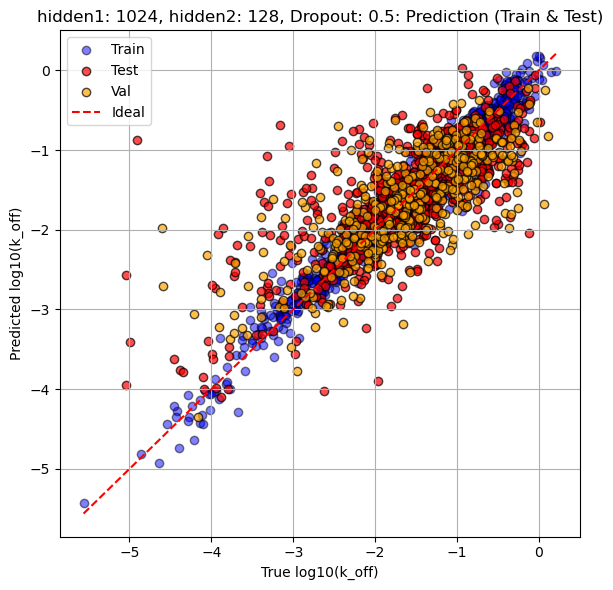

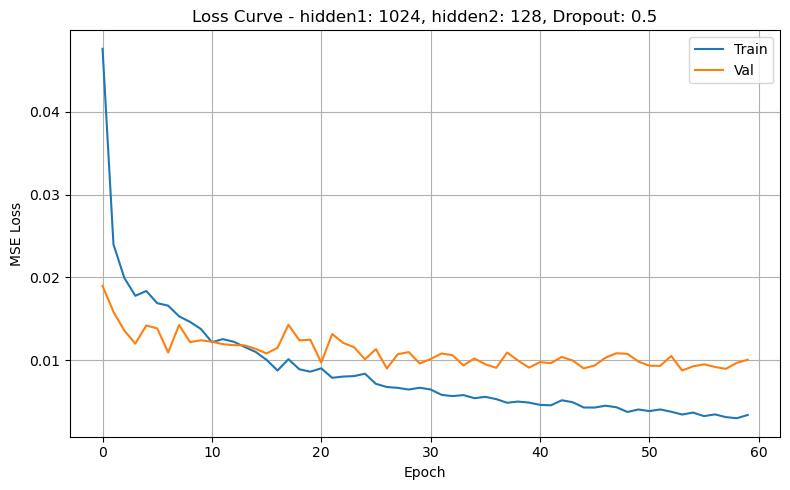

MSE: 0.3401, R² Test 0.5508

Testing model with hidden1=1024, hidden2=256, dropout=0.1
Final TEST loss: 0.0105


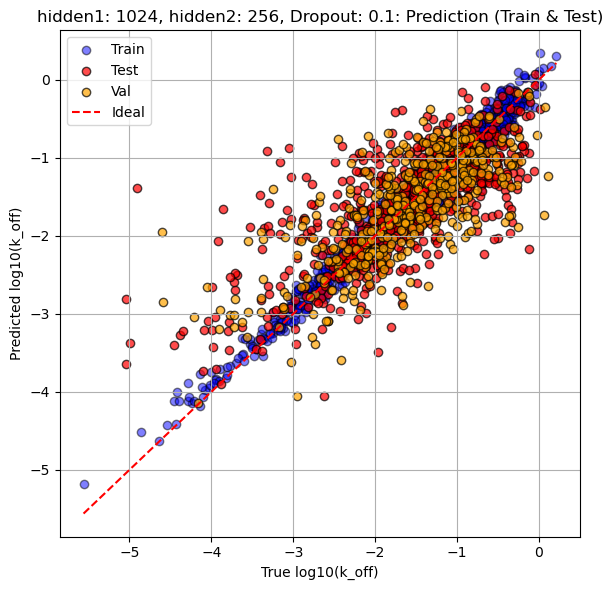

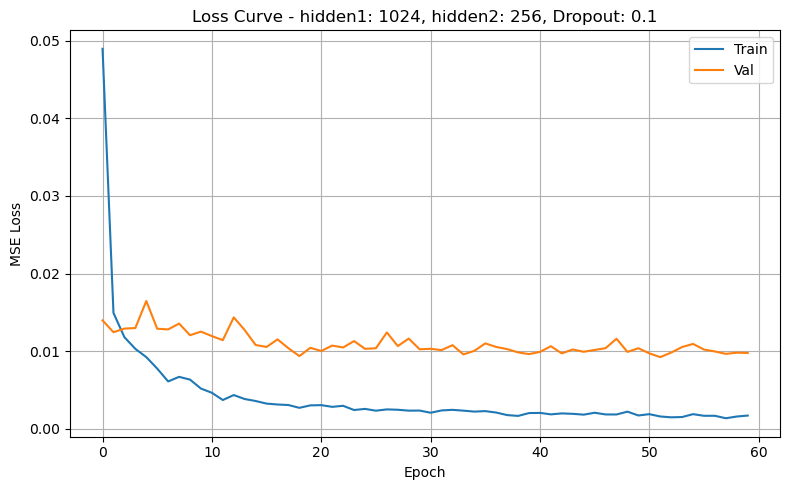

MSE: 0.3479, R² Test 0.5405

Testing model with hidden1=1024, hidden2=256, dropout=0.3
Final TEST loss: 0.0103


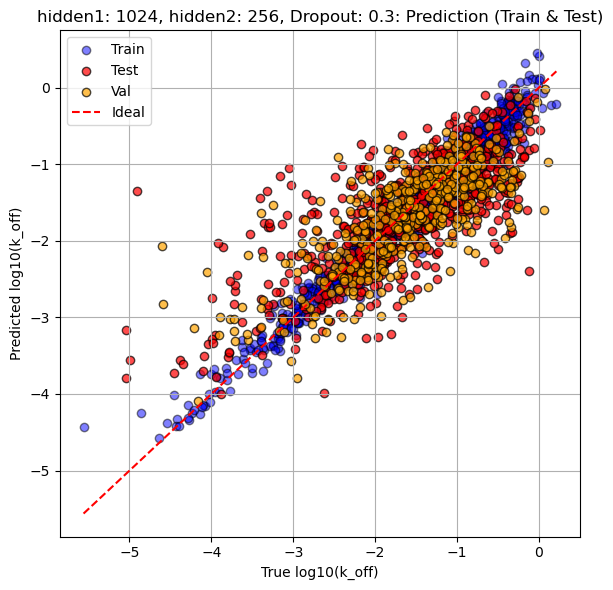

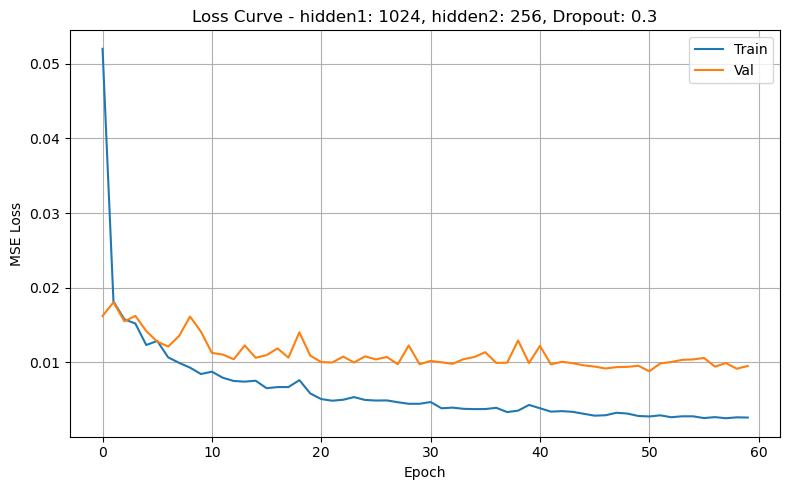

MSE: 0.3398, R² Test 0.5512

Testing model with hidden1=1024, hidden2=256, dropout=0.5
Final TEST loss: 0.0102


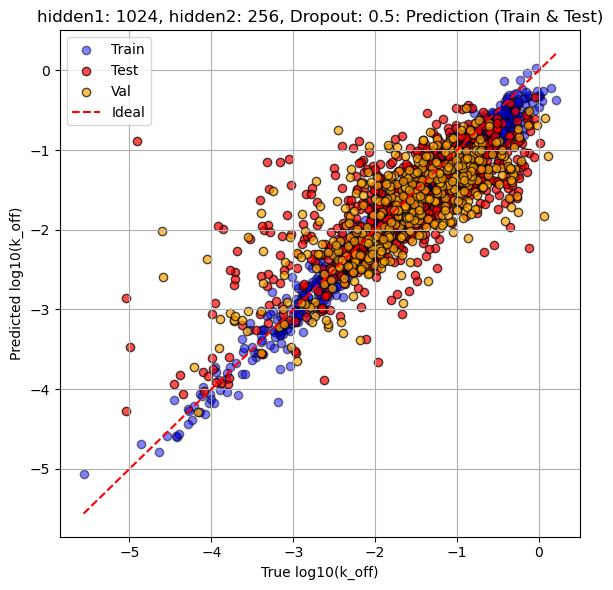

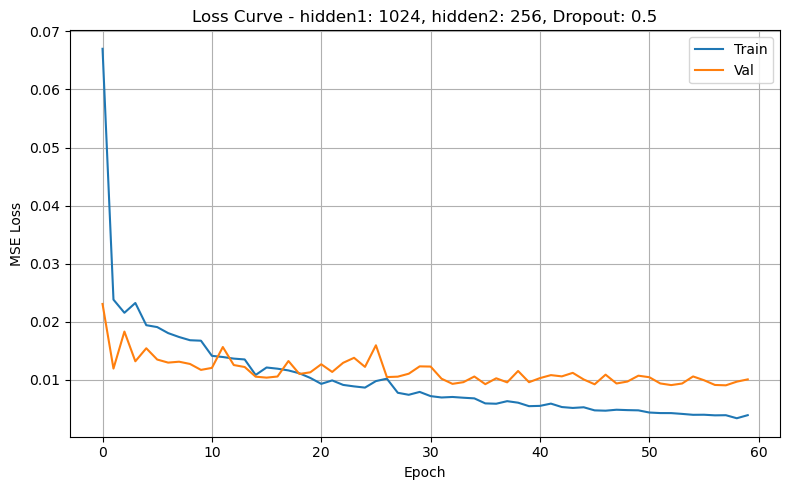

MSE: 0.3355, R² Test 0.5568
                   0      1      2      3      4      5
0   (1024, 256, 0.5)  0.336  0.946  0.558  0.557 -0.013
1   (1024, 256, 0.3)  0.340  0.956  0.571  0.551 -0.179
2   (1024, 128, 0.5)  0.340  0.952  0.564  0.551  0.142
3   (1024, 128, 0.3)  0.341  0.969  0.556  0.550 -0.040
4    (512, 256, 0.3)  0.345  0.958  0.574  0.544 -0.022
5    (512, 256, 0.1)  0.348  0.976  0.560  0.541 -0.142
6   (1024, 256, 0.1)  0.348  0.970  0.550  0.541 -0.371
7    (256, 128, 0.5)  0.348  0.888  0.558  0.540  0.207
8    (256, 256, 0.5)  0.349  0.865  0.515  0.540  0.056
9    (512, 256, 0.5)  0.349  0.937  0.565  0.538  0.149
10  (1024, 128, 0.1)  0.351  0.965  0.559  0.536 -0.320
11   (256, 128, 0.3)  0.352  0.935  0.539  0.535 -0.095
12   (512, 128, 0.5)  0.353  0.939  0.571  0.533  0.120
13   (512, 128, 0.3)  0.358  0.960  0.564  0.527  0.091
14   (256, 128, 0.1)  0.366  0.962  0.543  0.517 -0.185
15   (512, 128, 0.1)  0.366  0.951  0.543  0.516 -0.586
16   (256, 256, 0.1)

In [ ]:
class NN_regression_tune(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout_ratio):
        super().__init__()
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.layer1   = nn.Linear(input_dim, hidden1)
        self.dropout2 = nn.Dropout(dropout_ratio)
        self.layer2   = nn.Linear(hidden1, hidden2)
        self.output   = nn.Linear(hidden2, 1)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.layer1(x))
        x = self.dropout2(x)
        x = F.relu(self.layer2(x))
        return self.output(x)


# Training and evaluation function
def train_and_evaluate_model(input_dim, h1, h2, d, train_loader, test_loader, y_scaler):
    modelname = f"h1{h1}_h2{h2}_do{d}"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPU if available
    model = NN_regression_tune(input_dim, h1, h2, d).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    
    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_model_path = f"best_model_{modelname}.pt"
    n_epochs=60

    for epoch in range(n_epochs):  # n_epochs, so far 100 is the best
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad() #reset gradients
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        val_loss=0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
                pred = model(xb)
                loss = loss_fn(pred, yb)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            
    
    model.load_state_dict(torch.load(best_model_path)) #loading the best model

    # Evaluation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        # Test predictions
        y_test_pred_scaled = model(test_ds.tensors[0]).numpy()
        y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
        y_test_true = y_scaler.inverse_transform(test_ds.tensors[1].numpy())

        # Train predictions
        y_train_pred_scaled = model(train_ds.tensors[0]).numpy()
        y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
        y_train_true = y_scaler.inverse_transform(train_ds.tensors[1].numpy())
        
        #validation predictions
        y_val_pred_scaled=model(val_ds.tensors[0]).numpy()
        y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)
        y_val_true = y_scaler.inverse_transform(val_ds.tensors[1].numpy())
        
        #validation predictions
        y_holdout_pred_scaled=model(holdout_ds.tensors[0]).numpy()
        y_holdout_pred = y_scaler.inverse_transform(y_holdout_pred_scaled)
        y_holdout_true = y_scaler.inverse_transform(holdout_ds.tensors[1].numpy())
        
        # FINAL TEST EVALUATION (once)
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            test_loss += loss_fn(pred, yb).item()
    avg_test_loss = test_loss / len(test_loader)
    print(f"Final TEST loss: {avg_test_loss:.4f}")

    mse = mean_squared_error(y_test_true, y_test_pred)
    r2_train =r2_score(y_train_true, y_train_pred)
    r2_val =  r2_score(y_val_true, y_val_pred)
    r2_test = r2_score(y_test_true, y_test_pred)
    r2_holdout = r2_score(y_holdout_true, y_holdout_pred)
    
    #scatter plot of predicted vs true values
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_true, y_train_pred, alpha=0.5, label='Train', c='blue', edgecolors='k')
    plt.scatter(y_test_true, y_test_pred, alpha=0.7, label='Test', c='red', edgecolors='k')
    plt.scatter(y_val_true, y_val_pred,  alpha=0.7, label='Val', c='orange', edgecolors='k')
    min_val = min(y_train_true.min(), y_test_true.min())
    max_val = max(y_train_true.max(), y_test_true.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
    plt.xlabel("True log10(k_off)")
    plt.ylabel("Predicted log10(k_off)")
    plt.title(f"hidden1: {h1}, hidden2: {h2}, Dropout: {d}: Prediction (Train & Test)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.title(f"Loss Curve - hidden1: {h1}, hidden2: {h2}, Dropout: {d}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

        

    return mse, r2_train, r2_val, r2_test, r2_holdout




# Define hyperparameter grid
hidden1_options = [256, 512, 1024]
hidden2_options = [128, 256]
dropout_options = [0.1, 0.3, 0.5]

# Run tests 
input_dim = X_tensor.shape[1]
results = []

for h1 in hidden1_options:
    for h2 in hidden2_options:
        for d in dropout_options:
            print(f"\nTesting model with hidden1={h1}, hidden2={h2}, dropout={d}")
            mse, r2_train, r2_val, r2_test, r2_holdout = train_and_evaluate_model(input_dim, h1, h2, d, train_loader, test_loader, y_scaler)
            print(f"MSE: {mse:.4f}, R² Test {r2_test:.4f}")
            results.append(((h1, h2, d), mse, r2_train, r2_val, r2_test, r2_holdout))

# Sort and print the best results
results.sort(reverse=True, key=lambda x: x[3])  # sort by R^2 from Validation
results_df = pd.DataFrame(results)
print(results_df)

print("\nTop models:")
for config, mse, r2_train, r2_val, r2_test, r2_holdout in results[:3]:
    print(f"hidden1={config[0]}, hidden2={config[1]}, dropout={config[2]} => MSE: {mse:.4f}, R² Train: {r2_train:.4f}, R² Val: {r2_val:.4f}, R² Test: {r2_test:.4f}, R² Holdout: {r2_holdout:.4f}")

Best Results , based on the best performance on Val R^2-> Config of Index 4 : (512, 256, 0.3) MSE: 0.345 Train: 0.958 Val: 0.574 Test: 0.544  Holdou: -0.022


Visualization of the best Model on n=100

Training on ligand features:Morgan_Fingerprints and kinase features: Pocket_Sequences_propy
Epoch 1/100, Train Loss: 0.0728
Epoch 2/100, Train Loss: 0.0201
Epoch 3/100, Train Loss: 0.0172
Epoch 4/100, Train Loss: 0.0160
Epoch 5/100, Train Loss: 0.0159
Epoch 6/100, Train Loss: 0.0128
Epoch 7/100, Train Loss: 0.0123
Epoch 8/100, Train Loss: 0.0116
Epoch 9/100, Train Loss: 0.0109
Epoch 10/100, Train Loss: 0.0113
Epoch 11/100, Train Loss: 0.0101
Epoch 12/100, Train Loss: 0.0121
Epoch 13/100, Train Loss: 0.0092
Epoch 14/100, Train Loss: 0.0085
Epoch 15/100, Train Loss: 0.0078
Epoch 16/100, Train Loss: 0.0077
Epoch 17/100, Train Loss: 0.0082
Epoch 18/100, Train Loss: 0.0077
Epoch 19/100, Train Loss: 0.0073
Epoch 20/100, Train Loss: 0.0074
Epoch 21/100, Train Loss: 0.0072
Epoch 22/100, Train Loss: 0.0064
Epoch 23/100, Train Loss: 0.0062
Epoch 24/100, Train Loss: 0.0063
Epoch 25/100, Train Loss: 0.0066
Epoch 26/100, Train Loss: 0.0055
Epoch 27/100, Train Loss: 0.0048
Epoch 28/100, Train Loss: 

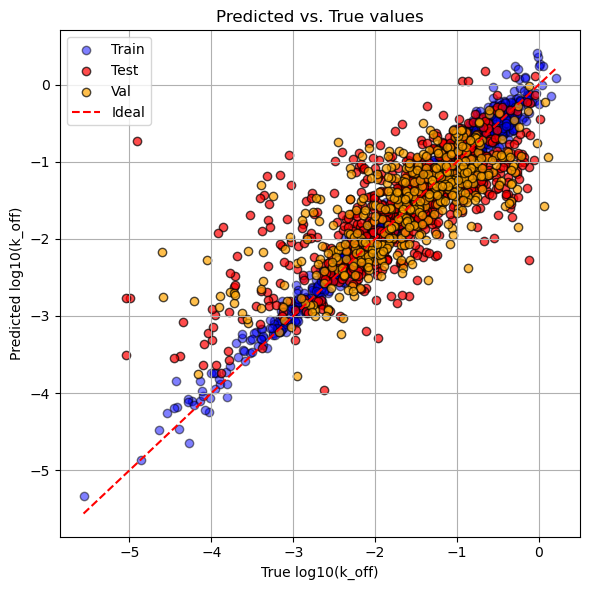

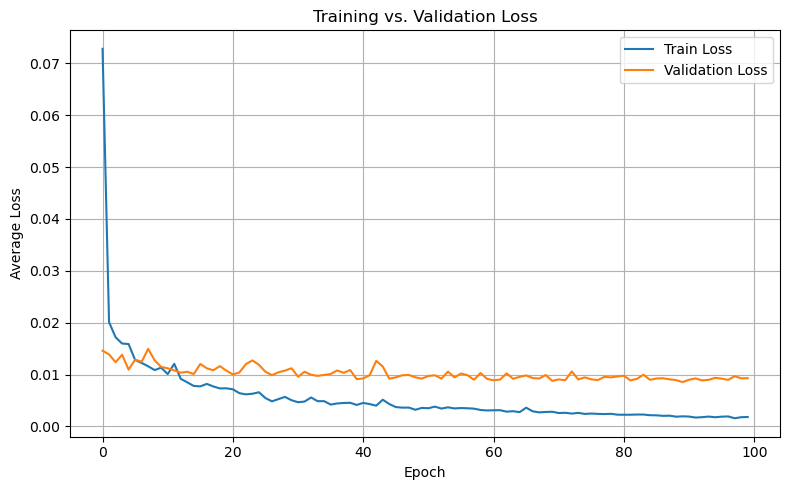

In [14]:
#seed
# global random seed
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)

#Best architecture
dropout_ratio=0.3 #0.5
hidden1=512 #1024
hidden2=256 #128

class NN_regression(nn.Module):
    def __init__(self, in_len, out_len=1, dropout_ratio=dropout_ratio):
        super().__init__()
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.layer1   = nn.Linear(in_len, 1024)
        self.dropout2 = nn.Dropout(dropout_ratio)
        self.layer2   = nn.Linear(1024, 128)
        self.output   = nn.Linear(128, out_len)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.layer1(x))
        x = self.dropout2(x)
        x = F.relu(self.layer2(x))
        return self.output(x)

#training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPU if available
model = NN_regression(in_len=X_tensor.shape[1]).to(device) #size of the input layer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #default learning rate is 0.001
loss_fn = nn.MSELoss()

#training Loop
n_epochs = 100
train_losses, val_losses = [], []  # Liste zur Speicherung der avg_loss pro Epoche

#early stopper
#early_stopper = EarlyStopper(patience=20, min_delta=0.0001) #standard min_delta is 0.001
best_weights = copy.deepcopy(model.state_dict()) #save initial weights
best_val_loss = float('inf') #initialize best val loss to infinity


print(f"Training on ligand features:{feature_set_ligand} and kinase features: {feature_set_kinase}")

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad() #zero the parameter gradients
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # Loss speichern


     # validierung
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    #track best model weights
    if avg_val_loss < best_val_loss: #-early_stopper.min_delta:
        best_val_loss = avg_val_loss
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_loss:.4f}")
    
    #early stopping check
    #if early_stopper.early_stop(avg_val_loss):
     #   print(f"Early stopping triggered at epoch {epoch+1}.")
      #  break
#load best model weights after training
model.load_state_dict(best_weights)

# FINAL TEST EVALUATION (once)
model.eval()
test_loss = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        test_loss += loss_fn(pred, yb).item()
avg_test_loss = test_loss / len(test_loader)
print(f"Final TEST loss: {avg_test_loss:.4f}")



# evaluierung
model.eval()
with torch.no_grad():
    #test predictions

    y_test_pred_scaled = model(test_ds.tensors[0]).numpy()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
    y_test_true = y_scaler.inverse_transform(test_ds.tensors[1].numpy())

    # Train Predictions
    y_train_pred_scaled = model(train_ds.tensors[0]).numpy()
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
    y_train_true = y_scaler.inverse_transform(train_ds.tensors[1].numpy())
    
    #validation predictions
    y_val_pred_scaled=model(val_ds.tensors[0]).numpy()
    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)
    y_val_true = y_scaler.inverse_transform(val_ds.tensors[1].numpy())
    
    #validation predictions
    y_holdout_pred_scaled=model(holdout_ds.tensors[0]).numpy()
    y_holdout_pred = y_scaler.inverse_transform(y_holdout_pred_scaled)
    y_holdout_true = y_scaler.inverse_transform(holdout_ds.tensors[1].numpy())
    
    


mse = mean_squared_error(y_test_true, y_test_pred)
r2 = r2_score(y_test_true, y_test_pred)
r2_train = r2_score(y_train_true, y_train_pred)
r2_val = r2_score(y_val_true, y_val_pred)
r2_holdout = r2_score(y_holdout_true, y_holdout_pred)

print(f"Finished Training on Hidden1:{hidden1} , Hidden2: {hidden2} and Dropout: {dropout_ratio}")
print(f"\nTest MSE: {mse:.4f} |Test R²: {r2:.4f} | Train R²: {r2_train:.4f} | Val R²: {r2_val:.4f}| Holdout R2: {r2_holdout:.4f} | best epoch { np.argmin(val_losses) + 1}")

#scatter plot of predicted vs true values
plt.figure(figsize=(6, 6))
plt.scatter(y_train_true, y_train_pred, alpha=0.5, label='Train', color='blue', edgecolors='k')
plt.scatter(y_test_true, y_test_pred, alpha=0.7, label='Test', c='red', edgecolors='k')
plt.scatter(y_val_true, y_val_pred,  alpha=0.7, label='Val', c='orange', edgecolors='k')
min_val = min(y_train_true.min(), y_test_true.min())
max_val = max(y_train_true.max(), y_test_true.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
plt.xlabel("True log10(k_off)")
plt.ylabel("Predicted log10(k_off)")
plt.title("Predicted vs. True values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#plot der training + validation losse

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", color="tab:blue")
plt.plot(val_losses, label="Validation Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Different activation Functions

Training on Activation function: relu
Epoch 1/100, Train Loss: 0.0486, Val: 0.0138
Epoch 2/100, Train Loss: 0.0154, Val: 0.0129
Epoch 3/100, Train Loss: 0.0149, Val: 0.0115
Epoch 4/100, Train Loss: 0.0133, Val: 0.0123
Epoch 5/100, Train Loss: 0.0123, Val: 0.0152
Epoch 6/100, Train Loss: 0.0110, Val: 0.0111
Epoch 7/100, Train Loss: 0.0106, Val: 0.0111
Epoch 8/100, Train Loss: 0.0095, Val: 0.0120
Epoch 9/100, Train Loss: 0.0091, Val: 0.0131
Epoch 10/100, Train Loss: 0.0080, Val: 0.0132
Epoch 11/100, Train Loss: 0.0082, Val: 0.0125
Epoch 12/100, Train Loss: 0.0076, Val: 0.0110
Epoch 13/100, Train Loss: 0.0071, Val: 0.0121
Epoch 14/100, Train Loss: 0.0072, Val: 0.0130
Epoch 15/100, Train Loss: 0.0068, Val: 0.0117
Epoch 16/100, Train Loss: 0.0061, Val: 0.0101
Epoch 17/100, Train Loss: 0.0059, Val: 0.0105
Epoch 18/100, Train Loss: 0.0062, Val: 0.0112
Epoch 19/100, Train Loss: 0.0058, Val: 0.0123
Epoch 20/100, Train Loss: 0.0063, Val: 0.0119
Epoch 21/100, Train Loss: 0.0053, Val: 0.0107
Epoch

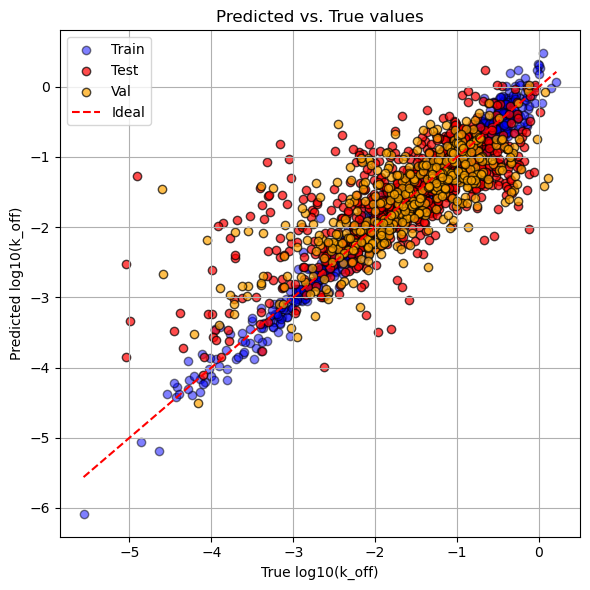

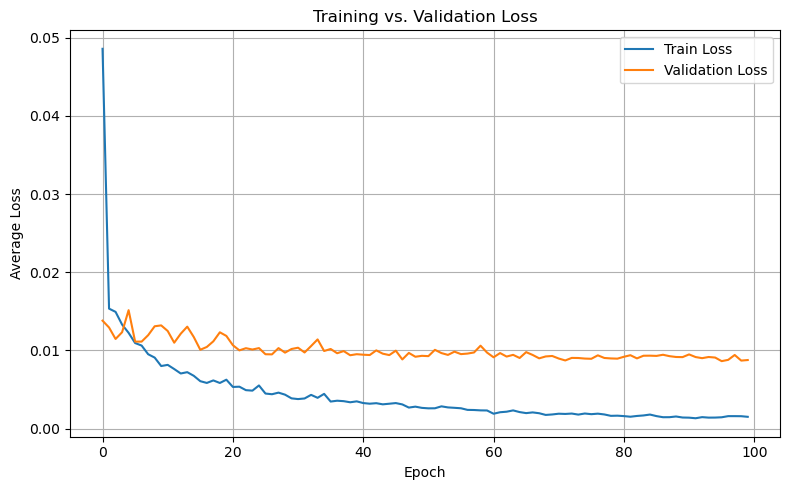

Training on Activation function: silu
Epoch 1/100, Train Loss: 0.0497, Val: 0.0126
Epoch 2/100, Train Loss: 0.0138, Val: 0.0116
Epoch 3/100, Train Loss: 0.0138, Val: 0.0123
Epoch 4/100, Train Loss: 0.0120, Val: 0.0117
Epoch 5/100, Train Loss: 0.0119, Val: 0.0108
Epoch 6/100, Train Loss: 0.0094, Val: 0.0124
Epoch 7/100, Train Loss: 0.0096, Val: 0.0104
Epoch 8/100, Train Loss: 0.0092, Val: 0.0101
Epoch 9/100, Train Loss: 0.0084, Val: 0.0108
Epoch 10/100, Train Loss: 0.0074, Val: 0.0115
Epoch 11/100, Train Loss: 0.0071, Val: 0.0104
Epoch 12/100, Train Loss: 0.0068, Val: 0.0101
Epoch 13/100, Train Loss: 0.0056, Val: 0.0098
Epoch 14/100, Train Loss: 0.0057, Val: 0.0111
Epoch 15/100, Train Loss: 0.0053, Val: 0.0097
Epoch 16/100, Train Loss: 0.0050, Val: 0.0093
Epoch 17/100, Train Loss: 0.0044, Val: 0.0100
Epoch 18/100, Train Loss: 0.0047, Val: 0.0096
Epoch 19/100, Train Loss: 0.0045, Val: 0.0105
Epoch 20/100, Train Loss: 0.0040, Val: 0.0090
Epoch 21/100, Train Loss: 0.0034, Val: 0.0097
Epoch

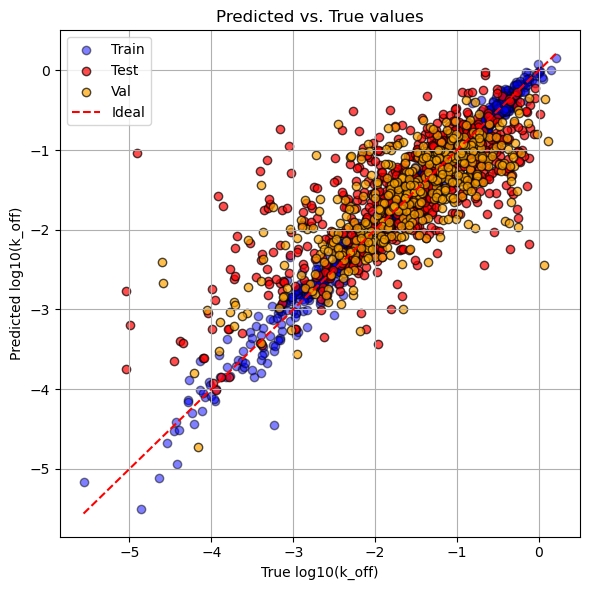

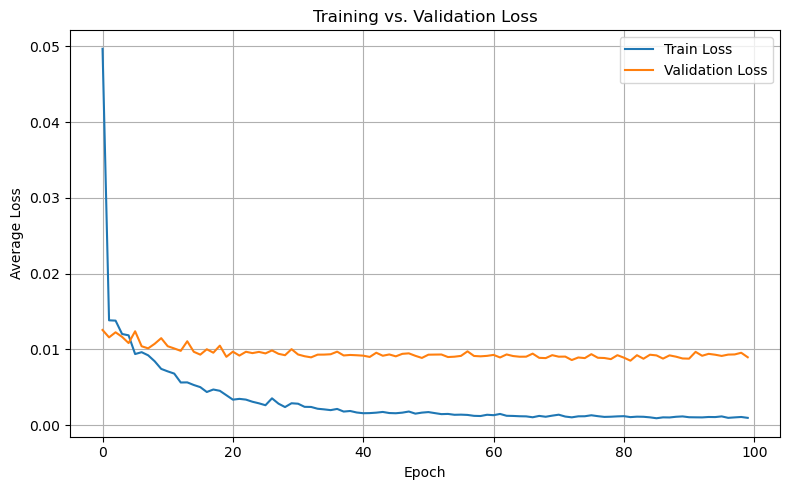

Training on Activation function: sigmoid
Epoch 1/100, Train Loss: 0.0415, Val: 0.0128
Epoch 2/100, Train Loss: 0.0129, Val: 0.0114
Epoch 3/100, Train Loss: 0.0126, Val: 0.0116
Epoch 4/100, Train Loss: 0.0123, Val: 0.0109
Epoch 5/100, Train Loss: 0.0124, Val: 0.0104
Epoch 6/100, Train Loss: 0.0119, Val: 0.0120
Epoch 7/100, Train Loss: 0.0125, Val: 0.0147
Epoch 8/100, Train Loss: 0.0126, Val: 0.0103
Epoch 9/100, Train Loss: 0.0114, Val: 0.0122
Epoch 10/100, Train Loss: 0.0110, Val: 0.0106
Epoch 11/100, Train Loss: 0.0104, Val: 0.0098
Epoch 12/100, Train Loss: 0.0095, Val: 0.0099
Epoch 13/100, Train Loss: 0.0089, Val: 0.0095
Epoch 14/100, Train Loss: 0.0088, Val: 0.0113
Epoch 15/100, Train Loss: 0.0085, Val: 0.0105
Epoch 16/100, Train Loss: 0.0079, Val: 0.0094
Epoch 17/100, Train Loss: 0.0077, Val: 0.0106
Epoch 18/100, Train Loss: 0.0083, Val: 0.0099
Epoch 19/100, Train Loss: 0.0073, Val: 0.0096
Epoch 20/100, Train Loss: 0.0075, Val: 0.0104
Epoch 21/100, Train Loss: 0.0064, Val: 0.0104
Ep

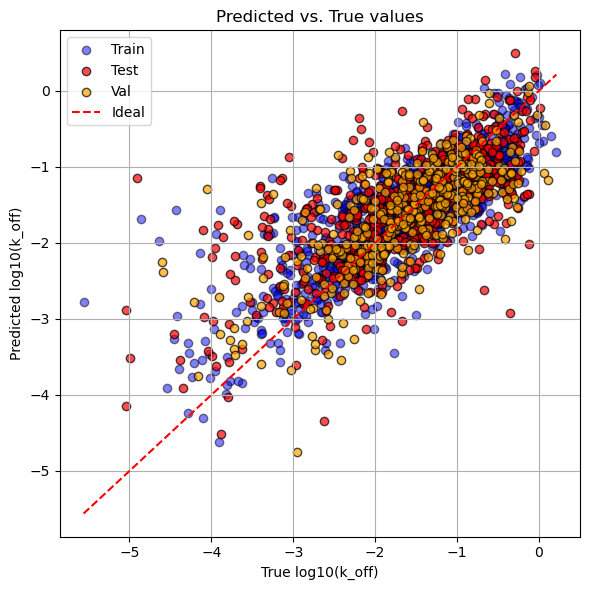

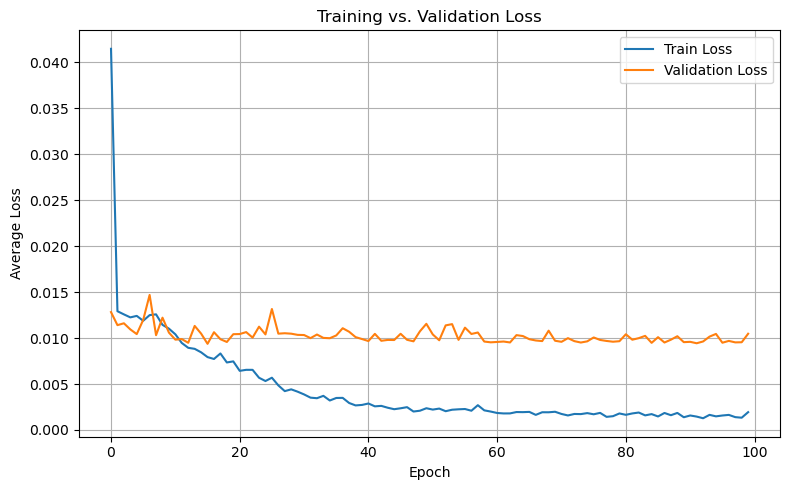

Training on Activation function: tanh
Epoch 1/100, Train Loss: 0.0598, Val: 0.0133
Epoch 2/100, Train Loss: 0.0175, Val: 0.0119
Epoch 3/100, Train Loss: 0.0152, Val: 0.0123
Epoch 4/100, Train Loss: 0.0160, Val: 0.0166
Epoch 5/100, Train Loss: 0.0140, Val: 0.0114
Epoch 6/100, Train Loss: 0.0142, Val: 0.0145
Epoch 7/100, Train Loss: 0.0127, Val: 0.0135
Epoch 8/100, Train Loss: 0.0115, Val: 0.0122
Epoch 9/100, Train Loss: 0.0101, Val: 0.0115
Epoch 10/100, Train Loss: 0.0091, Val: 0.0150
Epoch 11/100, Train Loss: 0.0094, Val: 0.0111
Epoch 12/100, Train Loss: 0.0086, Val: 0.0117
Epoch 13/100, Train Loss: 0.0081, Val: 0.0104
Epoch 14/100, Train Loss: 0.0070, Val: 0.0120
Epoch 15/100, Train Loss: 0.0060, Val: 0.0120
Epoch 16/100, Train Loss: 0.0061, Val: 0.0118
Epoch 17/100, Train Loss: 0.0057, Val: 0.0116
Epoch 18/100, Train Loss: 0.0056, Val: 0.0113
Epoch 19/100, Train Loss: 0.0052, Val: 0.0109
Epoch 20/100, Train Loss: 0.0051, Val: 0.0113
Epoch 21/100, Train Loss: 0.0045, Val: 0.0107
Epoch

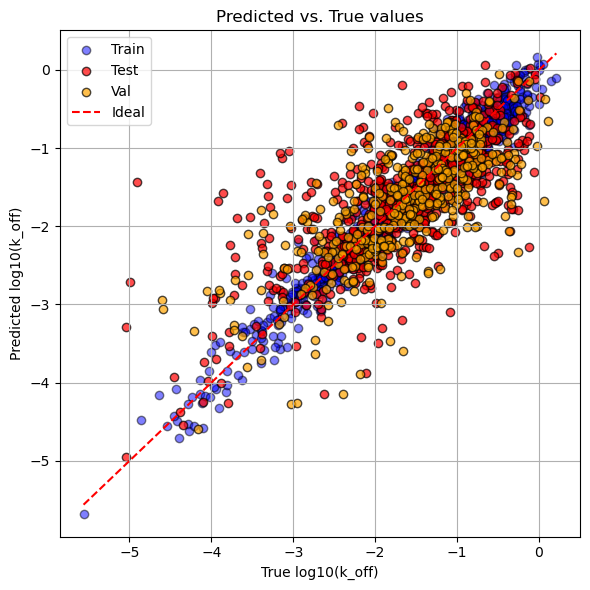

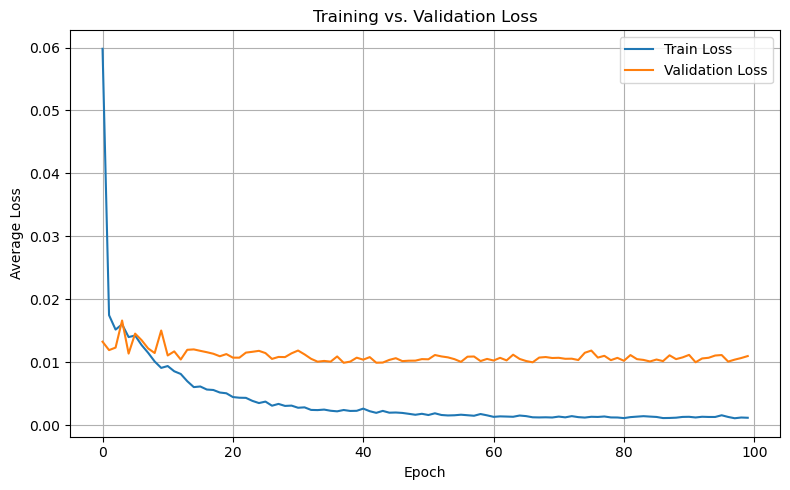

In [15]:
dropout_ratio=0.3
hidden1=512
hidden2=256
activation_fns = [F.relu, F.silu, torch.sigmoid, torch.tanh]
lr=0.001
n_epochs =100 

class NN_regression(nn.Module):
    def __init__(self, in_len, out_len=1, h1=hidden1, h2=hidden2, dropout=dropout_ratio, act=F.relu):
        super().__init__()
        self.act =act
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.layer1   = nn.Linear(in_len, h1)
        self.dropout2 = nn.Dropout(dropout_ratio)
        self.layer2   = nn.Linear(h1, h2)
        self.output   = nn.Linear(h2, out_len)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.act(self.layer1(x))
        x = self.dropout2(x)
        x = self.act(self.layer2(x))
        return self.output(x)
    

all_loss_curves = {}
results=[] 

def test_activation_functions(act_fn, h1, h2, d, lr):
    #training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPU if available
    model = NN_regression(in_len=X_tensor.shape[1], out_len=1, h1=h1, h2=h2, dropout=d, act=act_fn).to(device) #size of the input layer
    optimizer = torch.optim.Adam(model.parameters(), lr) #default learning rate is 0.001
    loss_fn = nn.MSELoss()

    #training Loop
    train_losses, val_losses = [], []  # Liste zur Speicherung der avg_loss pro Epoche

    #early stopper
    #early_stopper = EarlyStopper(patience=20, min_delta=0.0001) #standard min_delta is 0.001
    best_weights = copy.deepcopy(model.state_dict()) #save initial weights
    best_val_loss = float('inf') #initialize best val loss to infinity

    name = getattr(act_fn, "__name__", str(act_fn))
    print(f"Training on Activation function: {name}")

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad() #zero the parameter gradients
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)  # Loss speichern


        # validierung
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
                pred = model(xb)
                loss = loss_fn(pred, yb)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        #track best model weights
        if avg_val_loss < best_val_loss: #-early_stopper.min_delta:
            best_val_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_loss:.4f}, Val: {avg_val_loss:.4f}")
        
        #early stopping check
        #if early_stopper.early_stop(avg_val_loss):
        #   print(f"Early stopping triggered at epoch {epoch+1}.")
        #  break
    #load best model weights after training
    model.load_state_dict(best_weights)

    # FINAL TEST EVALUATION (once)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            test_loss += loss_fn(pred, yb).item()
    avg_test_loss = test_loss / len(test_loader)
    print(f"Final TEST loss: {avg_test_loss:.4f}")



    # evaluierung
    model.eval()
    with torch.no_grad():
        #test predictions

        y_test_pred_scaled = model(test_ds.tensors[0]).numpy()
        y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
        y_test_true = y_scaler.inverse_transform(test_ds.tensors[1].numpy())

        # Train Predictions
        y_train_pred_scaled = model(train_ds.tensors[0]).numpy()
        y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
        y_train_true = y_scaler.inverse_transform(train_ds.tensors[1].numpy())
        
        #validation predictions
        y_val_pred_scaled=model(val_ds.tensors[0]).numpy()
        y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)
        y_val_true = y_scaler.inverse_transform(val_ds.tensors[1].numpy())
        
        #validation predictions
        y_holdout_pred_scaled=model(holdout_ds.tensors[0]).numpy()
        y_holdout_pred = y_scaler.inverse_transform(y_holdout_pred_scaled)
        y_holdout_true = y_scaler.inverse_transform(holdout_ds.tensors[1].numpy())
        
        


    mse = mean_squared_error(y_test_true, y_test_pred)
    r2_test = r2_score(y_test_true, y_test_pred)
    r2_train = r2_score(y_train_true, y_train_pred)
    r2_val = r2_score(y_val_true, y_val_pred)
    r2_holdout = r2_score(y_holdout_true, y_holdout_pred)

    print(f"Finished Training on Hidden1:{hidden1} , Hidden2: {hidden2} and Dropout: {dropout_ratio}")
    print(f"\nTest MSE: {mse:.4f} |Test R²: {r2_test:.4f} | Train R²: {r2_train:.4f} | Val R²: {r2_val:.4f}| Holdout R2: {r2_holdout:.4f} | best epoch { np.argmin(val_losses) + 1}")
    
    all_loss_curves[name] = {"train": train_losses, "val": val_losses}
    results.append({
        "Activation Function": name,
        "MSE": mse,
        "Train R²": r2_train ,
        "Val R²": r2_val,
        "Test R²": r2_test,
        "Holdout R²": r2_holdout,
        "best epoch": int(np.argmin(val_losses)+1)
        
    })
    
    #scatter plot of predicted vs true values
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_true, y_train_pred, alpha=0.5, label='Train', color='blue', edgecolors='k')
    plt.scatter(y_test_true, y_test_pred, alpha=0.7, label='Test', c='red', edgecolors='k')
    plt.scatter(y_val_true, y_val_pred,  alpha=0.7, label='Val', c='orange', edgecolors='k')
    min_val = min(y_train_true.min(), y_test_true.min())
    max_val = max(y_train_true.max(), y_test_true.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
    plt.xlabel("True log10(k_off)")
    plt.ylabel("Predicted log10(k_off)")
    plt.title("Predicted vs. True values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    #plot der training + validation losse

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", color="tab:blue")
    plt.plot(val_losses, label="Validation Loss", color="tab:orange")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for act_fn in activation_fns:
    test_activation_functions(act_fn, hidden1, hidden2, dropout_ratio, lr)



    

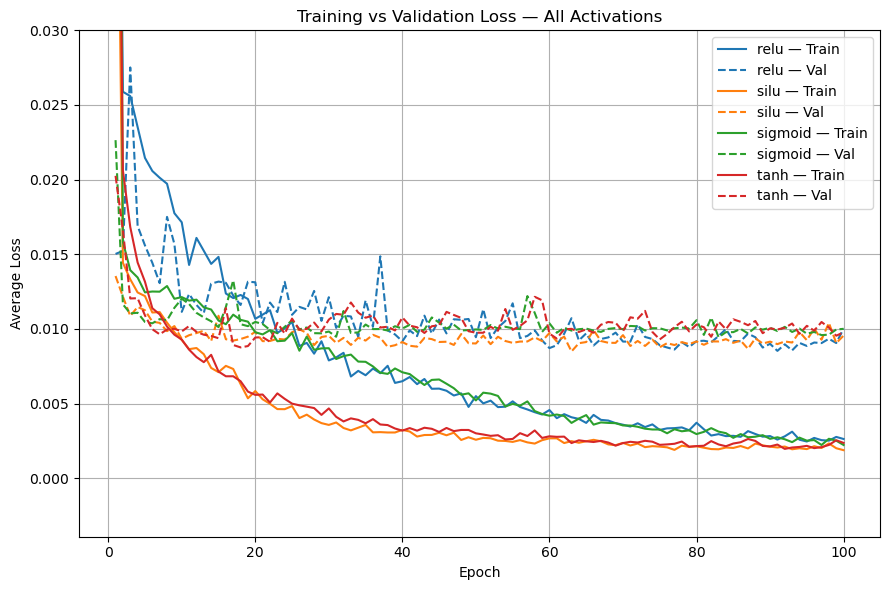

In [11]:
# plotting loss curves achieved by the different activation functions together
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))

for act_fn in activation_fns:
    name = getattr(act_fn, "__name__", str(act_fn))  #'relu', 'silu', 'sigmoid', 'tanh'
    if name not in all_loss_curves:
        continue  

    curves = all_loss_curves[name]
    train_losses = curves.get("train", [])
    val_losses   = curves.get("val", [])


    # plot: solid for train, dashed for val (same color via label pairing)
    line_train, = plt.plot(range(1, 101), train_losses, label=f"{name} — Train")
    plt.plot(range(1, 101), val_losses, linestyle="--", label=f"{name} — Val", 
             color=line_train.get_color())

plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.ylim(top=0.03)
plt.title("Training vs Validation Loss — All Activations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
